In [18]:
import numpy as np
import pandas as pd
import plotly as plot
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import sklearn 
import cufflinks as cf
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import plotly.offline as pyo
from plotly.offline import init_notebook_mode, plot, iplot

In [19]:
import opendatasets as od

In [20]:
dataset_url = 'https://www.kaggle.com/alxmamaev/flowers-recognition'

In [21]:
import os
import shutil

if os.path.exists('./flowers-recognition'):
    shutil.rmtree('./flowers-recognition')

In [22]:
od.download

<function opendatasets.download(dataset_id_or_url, data_dir='.', force=False, dry_run=False, **kwargs)>

In [23]:
dataset_url

'https://www.kaggle.com/alxmamaev/flowers-recognition'

In [24]:
od.download(dataset_url)

100%|██████████| 225M/225M [06:10<00:00, 636kB/s]  


In [25]:
data_dir = './flowers-recognition/flowers'

In [26]:
import os


In [27]:
os.listdir(data_dir)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [28]:
import shutil

In [29]:
import shutil

In [30]:
for cls in os.listdir(data_dir):
    print(cls, ':', len(os.listdir(data_dir + '/' + cls)))

daisy : 764
dandelion : 1052
rose : 784
sunflower : 733
tulip : 984


In [31]:
!pip install jovian --quiet

In [32]:
import jovian

<IPython.core.display.Javascript object>

In [33]:
from torchvision.datasets import ImageFolder

In [34]:
dataset = ImageFolder(data_dir)

In [35]:
len(dataset)

4317

In [36]:
dataset[50]

(<PIL.Image.Image image mode=RGB size=240x222>, 0)

In [37]:
dataset.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

In [39]:
import numpy as np

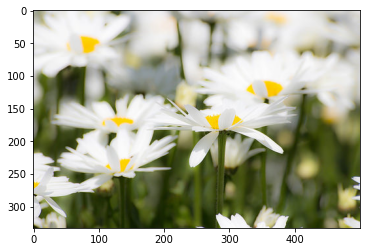

In [40]:
img, label = dataset[100]
plt.imshow(img)

In [41]:
import torchvision.transforms as tt

dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(64), 
                                            tt.RandomCrop(64), 
                                            tt.ToTensor()]))

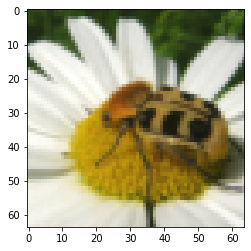

In [42]:
img, label = dataset[120]
plt.imshow(img.permute((1, 2, 0)))

In [43]:
val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

train_size, val_size

(3886, 431)

In [44]:
from torch.utils.data import random_split

train_ds, valid_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(valid_ds)

(3886, 431)

In [45]:
from torch.utils.data import DataLoader

batch_size = 128

train_dl = DataLoader(train_ds, 
                      batch_size, 
                      shuffle=True, 
                      num_workers=4, 
                      pin_memory=True)

valid_dl = DataLoader(valid_ds, 
                    batch_size, 
                    num_workers=4, 
                    pin_memory=True)

In [46]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break
    

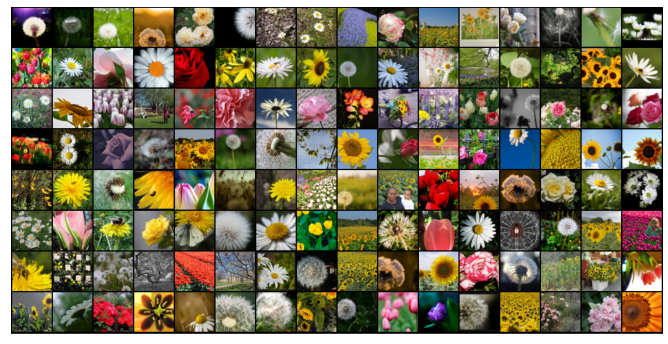

In [47]:
show_batch(train_dl)

In [48]:
import torch

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [49]:
torch.cuda.is_available()

False

In [50]:
device = get_default_device()

In [51]:
device

device(type='cpu')

In [52]:
img_gpu = to_device(img, device)
img_gpu.device

device(type='cpu')

In [53]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [54]:
# Model and training

In [55]:
import torch.nn as nn
import torch.nn.functional as F


In [56]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        "calculate loss for a batch of training data"
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        "calculate loss & accuracy for a batch of validation data"
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [57]:
def evaluate(model, val_loader):
    """Evaluates the model's performance on the validation set"""
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [58]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Input: 128 x 3 x 64 x 64
        self.conv1 = conv_block(in_channels, 64) # 128 x 64 x 64 x 64
        self.conv2 = conv_block(64, 128, pool=True) # 128 x 128 x 32 x 32
        self.res1 = nn.Sequential(conv_block(128, 128), # 128 x 128 x 32 x 32
                                  conv_block(128, 128)) # 128 x 128 x 32 x 32
        
        self.conv3 = conv_block(128, 256, pool=True) # 128 x 256 x 16 x 16
        self.conv4 = conv_block(256, 512, pool=True) # 128 x 512 x 8 x 8 
        self.res2 = nn.Sequential(conv_block(512, 512), # 128 x 512 x 8 x 8 
                                  conv_block(512, 512)) # 128 x 512 x 8 x 8 
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # 128 x 512 x 1 x 1 
                                        nn.Flatten(), # 128 x 512
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [59]:
def forward(self, X):
        X_shortcut = X
        X = F.relu(self.conv1(X))
        X =  self.conv1_bn(X)
        X = F.relu(self.conv2(X))
        X =  self.conv2_bn(X)
        X = F.relu(self.conv2(X))
        X =  self.conv2_bn(X)
        if (in_channels == out_channels):
            X = self.conv3(X) + X_shortcut
        else:
            X = self.conv3(X) + self.conv_shortcut(X_shortcut)
        X = self.conv3_bn(F.relu(x))
        return X

In [60]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Input: 128 x 3 x 64 x 64
        self.conv1 = conv_block(in_channels, 64) # 128 x 64 x 64 x 64
        self.conv2 = conv_block(64, 128, pool=True) # 128 x 128 x 32 x 32
        self.res1 = nn.Sequential(conv_block(128, 128), # 128 x 128 x 32 x 32
                                  conv_block(128, 128)) # 128 x 128 x 32 x 32
        
        self.conv3 = conv_block(128, 256, pool=True) # 128 x 256 x 16 x 16
        self.conv4 = conv_block(256, 512, pool=True) # 128 x 512 x 8 x 8 
        self.res2 = nn.Sequential(conv_block(512, 512), # 128 x 512 x 8 x 8 
                                  conv_block(512, 512)) # 128 x 512 x 8 x 8 
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # 128 x 512 x 1 x 1 
                                        nn.Flatten(), # 128 x 512
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [61]:
model = to_device(ResNet9(3, len(dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [62]:
model.conv1[0].weight.device

device(type='cpu')

In [63]:
torch.cuda.empty_cache()
for batch in train_dl:
    images, labels = batch
    print('images.shape', images.shape)
    print('images.device', images.device)
    preds = model(images)
    print('preds.shape', preds.shape)
    break

images.shape torch.Size([128, 3, 64, 64])
images.device cpu
preds.shape torch.Size([128, 5])


In [64]:
# Training

In [65]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.6070739030838013, 'val_acc': 0.2399434745311737}]

In [66]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 1.4045, val_loss: 1.8712, val_acc: 0.2913
Epoch [1], train_loss: 0.9129, val_loss: 0.9078, val_acc: 0.6367
Epoch [2], train_loss: 0.8069, val_loss: 0.9610, val_acc: 0.6468
Epoch [3], train_loss: 0.6894, val_loss: 0.9897, val_acc: 0.6949
Epoch [4], train_loss: 0.6766, val_loss: 0.9265, val_acc: 0.6730


In [67]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.7761, val_loss: 0.9977, val_acc: 0.6375
Epoch [1], train_loss: 0.6120, val_loss: 0.9241, val_acc: 0.6792
Epoch [2], train_loss: 0.5870, val_loss: 0.7390, val_acc: 0.7158
Epoch [3], train_loss: 0.5337, val_loss: 0.6527, val_acc: 0.7602
Epoch [4], train_loss: 0.4770, val_loss: 0.5864, val_acc: 0.7982


In [ ]:
# Use the below commands to increase the accuracy

In [68]:
# history += fit(5, 0.0001, model, train_dl, valid_dl, torch.optim.Adam)

In [69]:
# history += fit(5, 0.0001, model, train_dl, valid_dl)

In [72]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

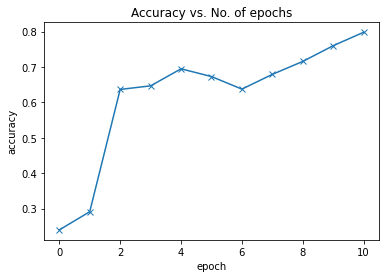

In [73]:
plot_accuracies(history)

In [74]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

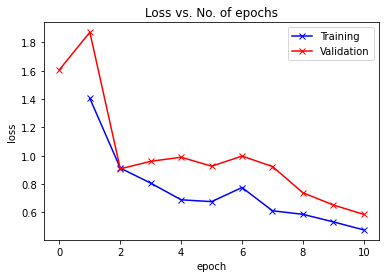

In [75]:
plot_losses(history)

In [76]:
history[-1]

{'val_loss': 0.586405336856842,
 'val_acc': 0.7981632351875305,
 'train_loss': 0.4769916236400604}

In [77]:
# jovian.reset()
# jovian.log_dataset(image_size=64)
# jovian.log_hyperparams(batch_size=128, 
#                        arch='ResNet9', 
#                        epochs=[5, 5, 5, 5], 
#                        lrs=[0.001, 0.001, 1e-4, 1e-4],
#                        opt=['Adam', 'Adam', 'Adam', 'SGD'])
# jovian.log_metrics(train_loss=history[-1]['train_loss'],
#                    val_acc=history[-1]['val_acc'],
#                    val_loss=history[-1]['val_loss'])

[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY:API KEY:API KEY:API KEY:API KEY:API KEY:API KEY:API KEY:

[jovian] Error: The current API key is invalid or expired.


[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY:API KEY:API KEY:API KEY:API KEY:API KEY:API KEY:API KEY:API KEY:API KEY:API KEY:


Abort: 

In [78]:
def predict_image(img, model, classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

In [79]:
def show_image_prediction(img, label):
    plt.imshow(img.permute((1, 2, 0)))
    pred = predict_image(img, model, dataset.classes)
    print('Target:', dataset.classes[label])
    print('Prediction:', pred)

Target: daisy
Prediction: daisy


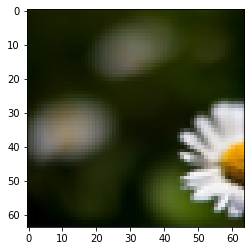

In [80]:
show_image_prediction(*valid_ds[100])

Target: sunflower
Prediction: sunflower


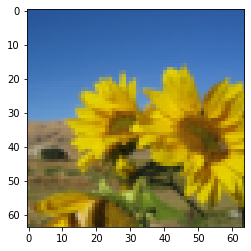

In [81]:
show_image_prediction(*valid_ds[300])

Target: tulip
Prediction: tulip


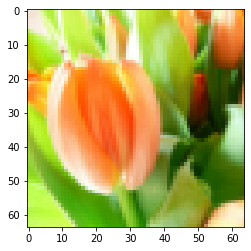

In [82]:
show_image_prediction(*valid_ds[12])

In [83]:
torch.save(model.state_dict(), 'flowers-resnet9.pth')

In [84]:
jovian


<module 'jovian' from 'c:\\Users\\Prayag Chawla\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\jovian\\__init__.py'>